## 1) Installer la librairie cliente

In [6]:
!pip -q install numpy
!pip -q install qdrant-client>=1.8.2 pandas sentence-transformers torch --upgrade

In [7]:
import os, ast, math
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch

# Modèle NLP (IA) qui transforme un texte (titre, résumé du film) en un vecteur numérique (embedding).
# C’est ce vecteur qui sera stocké dans Qdrant pour la recherche sémantique.
from sentence_transformers import SentenceTransformer
from qdrant_client import QdrantClient
from qdrant_client import models


## 2) URL du cluster et la clé API (sans exposer le secret)

In [9]:

from getpass import getpass

# URL du cluster Qdrant Cloud
QDRANT_URL = "https://25f79683-0e94-4712-af9f-84b3246092ae.europe-west3-0.gcp.cloud.qdrant.io"

QDRANT_API_KEY = getpass("Entrez votre Qdrant API Key (masqué) : ")

print("URL bien chargée. Clé API saisie (masquée).")


Entrez votre Qdrant API Key (masqué) : ··········
URL bien chargée. Clé API saisie (masquée).


## 3) Connexion au clusterCOLLECTION_NAME = "tmdb_movies"


In [10]:
COLLECTION_NAME = "tmdb_movies"

# Le modèle choisi pour générer les embeddings (dimension = 384).
# Avantages : rapide, léger, résultats corrects pour un projet académique.
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Torch device:", DEVICE)


try:
    client = QdrantClient(
        url=QDRANT_URL,
        api_key=QDRANT_API_KEY,
        timeout=30.0,
        prefer_grpc=False,
    )
    print("✅ Client Qdrant initialisé.")
except Exception as e:
    raise SystemExit(f"❌ Erreur d'initialisation du client Qdrant : {e}")


Torch device: cpu
✅ Client Qdrant initialisé.


### *Charger le dataset (CSV Kaggle) dans un DataFrame*

In [12]:
csv_path = "./content/tmdb_5000_movies.csv"

df = pd.read_csv(csv_path)
print(df.shape)
df.head(3)


(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


### *Nettoyage minimal (NaN, genres, dates)*

In [13]:
def parse_genres(x):
    """Convertit la chaîne JSON de genres en liste de noms."""
    if pd.isna(x) or not isinstance(x, str) or x.strip() == "":
        return []
    try:
        arr = ast.literal_eval(x)  # ex: "[{'id': 28, 'name': 'Action'}]"
        return [g.get("name") for g in arr if isinstance(g, dict) and "name" in g]
    except Exception:
        return []

# Colonnes attendues (varie selon le CSV choisi)
# Pour "tmdb_5000_movies": 'id','title','overview','genres','release_date','popularity','vote_average'
expected_cols = ["id","title","overview","genres","release_date","popularity","vote_average"]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("Colonnes manquantes dans ce CSV:", missing)

# Nettoyage de base
df["title"] = df["title"].fillna("").astype(str)
df["overview"] = df["overview"].fillna("").astype(str)
df["genres_list"] = df["genres"].apply(parse_genres) if "genres" in df.columns else [[]]

# Date
if "release_date" in df.columns:
    df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
else:
    df["release_date"] = pd.NaT

# Numériques
for col in ["popularity","vote_average"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)

# On garde des lignes avec au moins un texte pour faire un embedding
df = df[(df["overview"].str.strip() != "") | (df["title"].str.strip() != "")]
df = df.drop_duplicates(subset=["id"], keep="first")

print("Après clean:", df.shape)
df[["id","title","genres_list","release_date","popularity","vote_average"]].head(5)


Après clean: (4803, 21)


,id,title,genres_list,release_date,popularity,vote_average
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-10,150.437577,7.2
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",2007-05-19,139.082615,6.9
2,206647,Spectre,"[Action, Adventure, Crime]",2015-10-26,107.376788,6.3
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",2012-07-16,112.312950,7.6
4,49529,John Carter,"[Action, Adventure, Science Fiction]",2012-03-07,43.926995,6.1


### *Générer les embeddings (title+overview)*

In [14]:
# Texte = title + overview pour de meilleurs embeddings
texts = (df["title"].fillna("") + ". " + df["overview"].fillna("")).tolist()

model = SentenceTransformer(EMBEDDING_MODEL_NAME, device=DEVICE)
embedding_dim = model.get_sentence_embedding_dimension()
print("Embedding dim:", embedding_dim)

embeddings = []
batch_size = 256
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    embs = model.encode(batch, batch_size=64, convert_to_numpy=True, show_progress_bar=False, device=DEVICE, normalize_embeddings=True)
    embeddings.append(embs)
embeddings = np.vstack(embeddings)
embeddings.shape


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding dim: 384


  0%|          | 0/19 [00:00<?, ?it/s]

(4803, 384)

### *Creer la collection*

In [17]:
# (Re)création propre de la collection
client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=models.VectorParams(
        size=int(embedding_dim),        # dimension des embeddings (ici 384)
        distance=models.Distance.COSINE # mesure de similarité
    )
)

print("✅ Collection prête :", COLLECTION_NAME)


/tmp/ipython-input-3100594622.py:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


✅ Collection prête : tmdb_movies


In [18]:
## Upsert en lots dans Qdrant

def row_to_payload(row):
    return {
        "tmdb_id": int(row["id"]),
        "title": row["title"],
        "overview": row["overview"],
        "genres": row["genres_list"],
        "release_date": row["release_date"].strftime("%Y-%m-%d") if pd.notna(row["release_date"]) else None,
        "popularity": float(row["popularity"]) if "popularity" in row else None,
        "vote_average": float(row["vote_average"]) if "vote_average" in row else None,
        "ingested_at": pd.Timestamp.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    }

ids = df["id"].astype(int).tolist()
payloads = [row_to_payload(r) for _, r in df.iterrows()]

BATCH = 500
for i in tqdm(range(0, len(ids), BATCH)):
    batch_ids = ids[i:i+BATCH]
    batch_vectors = embeddings[i:i+BATCH]
    batch_payloads = payloads[i:i+BATCH]

    points = [
        models.PointStruct(
            id=int(batch_ids[j]),
            vector=batch_vectors[j].tolist(),
            payload=batch_payloads[j],
        )
        for j in range(len(batch_ids))
    ]

    client.upsert(collection_name=COLLECTION_NAME, points=points)

print("✅ Upsert terminé :", len(ids), "films")


  0%|          | 0/10 [00:00<?, ?it/s]

✅ Upsert terminé : 4803 films


## 4) Vérification : lister les collections existantes

In [19]:
try:
    collections = client.get_collections()
    print("Connexion OK ✅")
    print("Collections existantes :", [c.name for c in collections.collections])
except Exception as e:
    raise SystemExit(f"""
❌ Impossible de contacter Qdrant.
Vérifiez que l'URL et la clé API sont correctes, puis réexécutez la cellule.
Détails : {e}
""")


Connexion OK ✅
Collections existantes : ['tmdb_movies']


## 5) Test rapide de recherche sémantique

In [20]:
query_text = "un film de science-fiction avec des combats et un héros rebelle"
qvec = model.encode([query_text], normalize_embeddings=True)[0].tolist()

hits = client.search(
    collection_name=COLLECTION_NAME,
    query_vector=qvec,
    limit=5,
    with_payload=True,
)

for h in hits:
    p = h.payload
    print(f"{p.get('title')}  | score={h.score:.3f} | genres={p.get('genres')} | date={p.get('release_date')}")


/tmp/ipython-input-1364120788.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


Street Fighter  | score=0.499 | genres=['Action', 'Adventure', 'Thriller'] | date=1994-12-22
The Act of Killing  | score=0.468 | genres=['Documentary'] | date=2012-08-31
Battle: Los Angeles  | score=0.421 | genres=['Action', 'Science Fiction'] | date=2011-03-08
Gattaca  | score=0.419 | genres=['Thriller', 'Science Fiction', 'Mystery', 'Romance'] | date=1997-09-07
Watchmen  | score=0.419 | genres=['Action', 'Mystery', 'Science Fiction'] | date=2009-03-05


# CRUD

In [24]:
# Create (insertion)
import pandas as pd

new_movie = {
    "tmdb_id": 123456,
    "title": "L'Énigme IPSI",
    "overview": (
        "À l'école IPSI, un groupe d'étudiants en informatique découvre "
        "qu'un ancien serveur caché dans le sous-sol renferme une intelligence "
        "artificielle mystérieuse. Entre suspense, humour et technologie, "
        "ils vont devoir unir leurs compétences pour sauver leur campus… et peut-être le monde."
    ),
    "genres": ["Science-Fiction", "Comédie", "Thriller"],
    "release_date": "2025-09-24",
    "popularity": 42.0,
    "vote_average": 7.8,
    "ingested_at": pd.Timestamp.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
}

# Embedding pour ce film
vector = model.encode([new_movie["title"] + ". " + new_movie["overview"]], normalize_embeddings=True)[0].tolist()

client.upsert(
    collection_name=COLLECTION_NAME,
    points=[
        models.PointStruct(
            id=new_movie["tmdb_id"],
            vector=vector,
            payload=new_movie
        )
    ]
)

print("✅ Nouveau film inséré :", new_movie["title"])

✅ Nouveau film inséré : L'Énigme IPSI


In [26]:
# Read (lecture/recherche)

res = client.retrieve(collection_name=COLLECTION_NAME, ids=[123456])
print(res)

[Record(id=123456, payload={'tmdb_id': 123456, 'title': "L'Énigme IPSI", 'overview': "À l'école IPSI, un groupe d'étudiants en informatique découvre qu'un ancien serveur caché dans le sous-sol renferme une intelligence artificielle mystérieuse. Entre suspense, humour et technologie, ils vont devoir unir leurs compétences pour sauver leur campus… et peut-être le monde.", 'genres': ['Science-Fiction', 'Comédie', 'Thriller'], 'release_date': '2025-09-24', 'popularity': 42.0, 'vote_average': 7.8, 'ingested_at': '2025-09-24T11:53:19Z'}, vector=None, shard_key=None, order_value=None)]


In [27]:
# Update (mise à jour partielle)
client.set_payload(
    collection_name=COLLECTION_NAME,
    payload={"vote_average": 9.9, "popularity": 99.9},
    points=[123456]
)

print("✅ Film mis à jour")

✅ Film mis à jour


In [29]:
# Delete (suppression)
client.delete(
    collection_name=COLLECTION_NAME,
    points_selector=models.PointIdsList(points=[123456])
)

print("✅ Film supprimé")


✅ Film supprimé


# Rapport analytique dans le Notebook

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style par défaut
plt.style.use("seaborn-v0_8")

### *Films par genre*

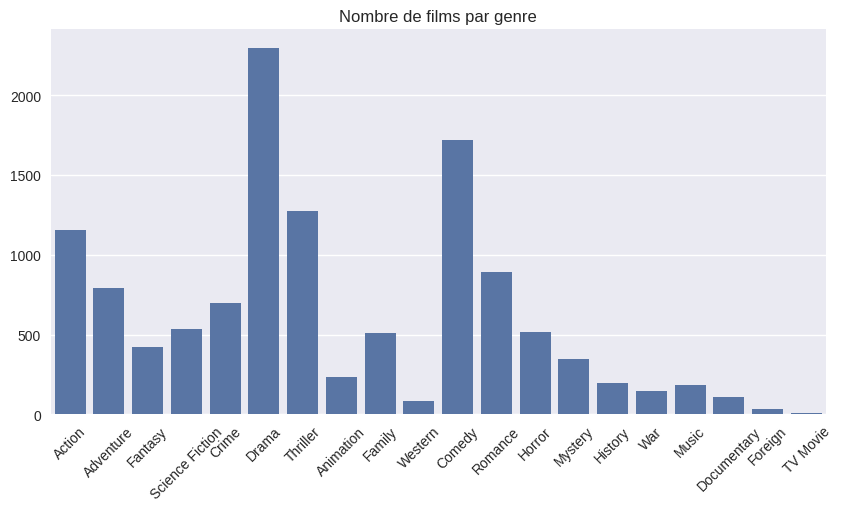

In [31]:
from collections import Counter

# Flatten la liste des genres
all_genres = [g for sub in df["genres_list"] for g in sub]
genre_counts = Counter(all_genres)

plt.figure(figsize=(10,5))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.xticks(rotation=45)
plt.title("Nombre de films par genre")
plt.show()

### *Note moyenne par décennie*

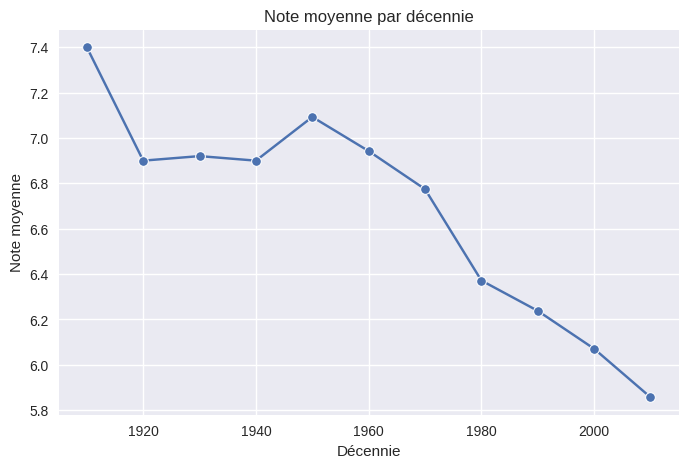

In [32]:
df["decade"] = (df["release_date"].dt.year // 10) * 10
decade_mean = df.groupby("decade")["vote_average"].mean().dropna()

plt.figure(figsize=(8,5))
sns.lineplot(x=decade_mean.index, y=decade_mean.values, marker="o")
plt.title("Note moyenne par décennie")
plt.xlabel("Décennie")
plt.ylabel("Note moyenne")
plt.show()

### *Popularité vs Note*

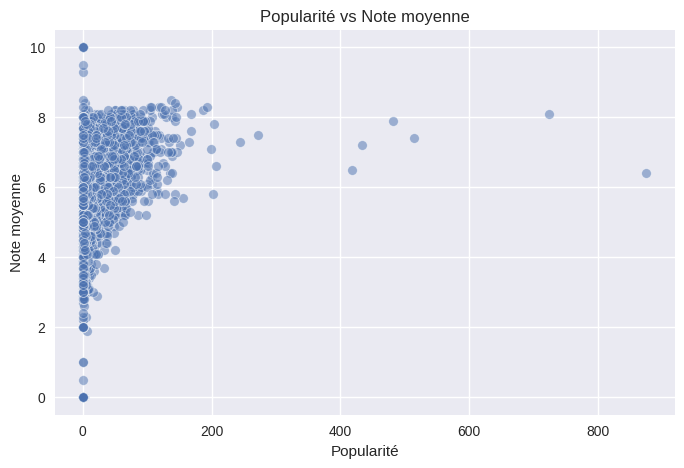

In [33]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="popularity", y="vote_average", alpha=0.5)
plt.title("Popularité vs Note moyenne")
plt.xlabel("Popularité")
plt.ylabel("Note moyenne")
plt.show()

### *Top 10 films récents (après 2015)*

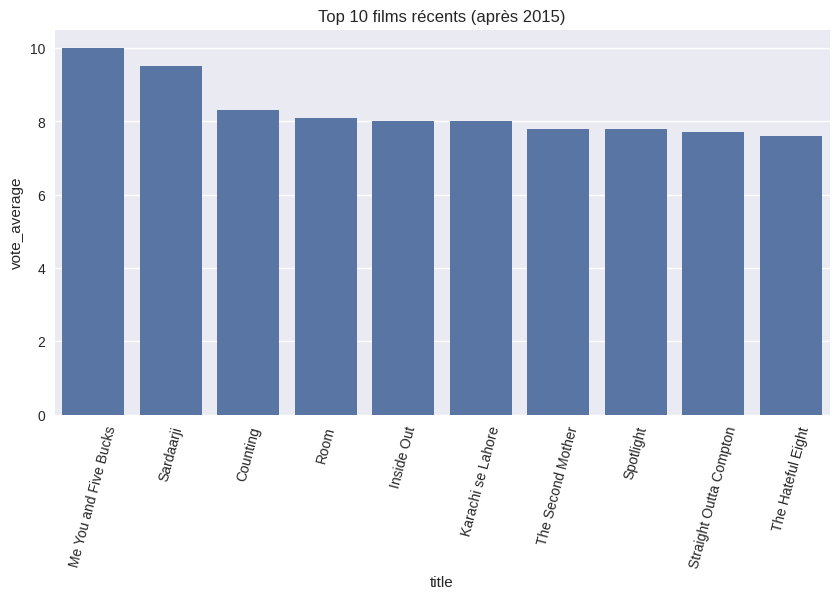

,title,release_date,vote_average,popularity
4247,Me You and Five Bucks,2015-07-07,10.0,0.094105
3992,Sardaarji,2015-06-26,9.5,0.296981
4755,Counting,2015-02-09,8.3,0.293587
2760,Room,2015-10-16,8.1,66.113340
77,Inside Out,2015-06-09,8.0,128.655964
4405,Karachi se Lahore,2015-07-31,8.0,0.060003
4303,The Second Mother,2015-02-08,7.8,9.683622
2123,Spotlight,2015-11-06,7.8,41.503588
1696,Straight Outta Compton,2015-08-13,7.7,61.762330
684,The Hateful Eight,2015-12-25,7.6,68.717016


In [34]:
recent = df[df["release_date"].dt.year >= 2015]
top10 = recent.sort_values("vote_average", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x="title", y="vote_average")
plt.xticks(rotation=75)
plt.title("Top 10 films récents (après 2015)")
plt.show()

top10[["title","release_date","vote_average","popularity"]]